Import Necessary Libraries

In [25]:
# Data handling
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloading NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Load the Dataset

In [26]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Data Cleaning

In [28]:
# Drop unnecessary columns
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [29]:
# Rename the Columns
data.rename(columns = {'v1':'label', 'v2':'text'}, inplace=True)

In [30]:
# Convert labels to numeric (0 = Ham, 1 = Spam)
data["label"] = data["label"].map({"ham": 0, "spam": 1})
data.head(5)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [31]:
#Check Missing Values
data.isnull().sum()

,0
label,0
text,0


In [32]:
# Check Duplicate Values
data.duplicated().sum()

403

In [33]:
# Remove Duplicate Values
data = data.drop_duplicates(keep='first')

In [34]:
data.shape

(5169, 2)

Exploratory Data Analysis

Label Distribution

In [35]:
values = data['label'].value_counts()
total = values.sum()

percentage_0 = (values[0] / total) * 100
percentage_1 = (values[1] / total) * 100

print(f'Percentage of class 0 -> Ham: {percentage_0:.2f}%')
print(f'Percentage of class 1 -> Spam: {percentage_1:.2f}%')

Percentage of class 0 -> Ham: 87.37%
Percentage of class 1 -> Spam: 12.63%


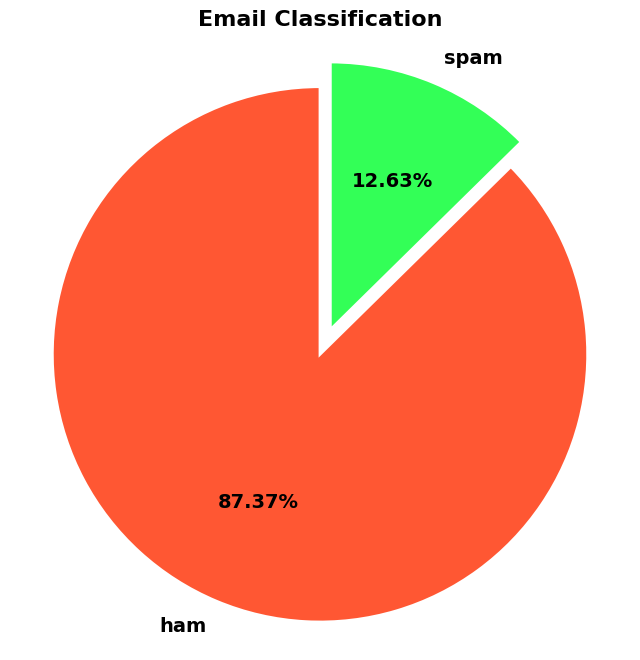

In [36]:
# Visualize the distribution of spam vs. ham
colors = ['#FF5733','#33FF57']
explode = (0,0.1)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('white')

wedges, texts, autotexts = ax.pie(
    values, labels=['ham','spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth':2, 'edgecolor':'white'},
    explode=explode,
    textprops={'color':'black'},
)

# Customize text properties
for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

# Add a title
ax.set_title('Email Classification', fontsize=16, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Show the pie chart
plt.show()

Text and Structure Analysis

In [37]:
data['num_characters'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x)))
data['num_words'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))
data['num_sentences'] = data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [38]:
data[['num_characters',"num_words",'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,18.455794,18.455794,1.965564
std,13.324758,13.324758,1.448541
min,1.000000,1.000000,1.000000
25%,9.000000,9.000000,1.000000
50%,15.000000,15.000000,1.000000
75%,26.000000,26.000000,2.000000
max,220.000000,220.000000,38.000000


In [40]:
# Summary statistics for legitimate messages
# ham
data[data['label'] == 0][['num_characters',"num_words",'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,17.123782,17.123782,1.820195
std,13.493970,13.493970,1.383657
min,1.000000,1.000000,1.000000
25%,8.000000,8.000000,1.000000
50%,13.000000,13.000000,1.000000
75%,22.000000,22.000000,2.000000
max,220.000000,220.000000,38.000000


In [41]:
# spam
data[data['label'] == 1][['num_characters',"num_words",'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,27.667688,27.667688,2.970904
std,7.008418,7.008418,1.488425
min,2.000000,2.000000,1.000000
25%,25.000000,25.000000,2.000000
50%,29.000000,29.000000,3.000000
75%,32.000000,32.000000,4.000000
max,46.000000,46.000000,9.000000


Character Length Distribution

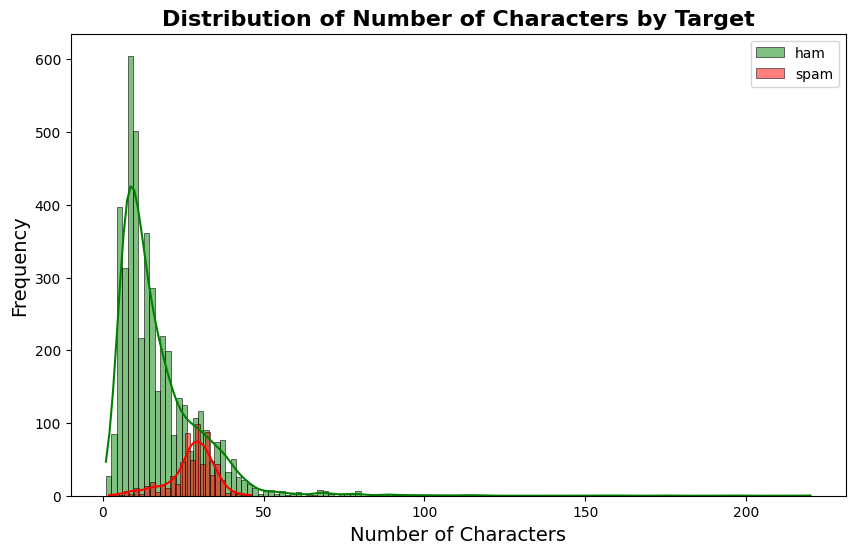

In [42]:
#Character Length Distribution
import seaborn as sns
plt.figure(figsize=(10,6))

sns.histplot(data[data['label'] == 0]['num_characters'], color='green', label='ham',kde=True)
sns.histplot(data[data['label'] == 1]['num_characters'], color='red', label='spam',kde=True)

# Add labels and a title
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Target', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='whitegrid')  # Add a white grid background

# Show the plot
plt.show()

Word Count Distribution

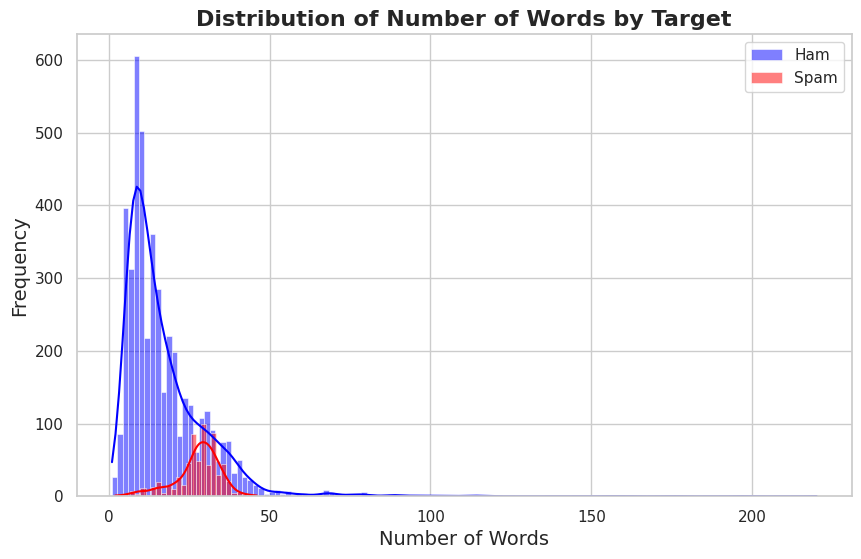

In [44]:
plt.figure(figsize=(10, 6))

# Plot the histogram for target 0 in blue
sns.histplot(data[data['label'] == 0]['num_words'], color='blue', label='Ham', kde=True)

# Plot the histogram for target 1 in red
sns.histplot(data[data['label'] == 1]['num_words'], color='red', label='Spam', kde=True)

# Add labels and a title
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='whitegrid')  # Add a white grid background

# Show the plot
plt.show()

Coorelation Matrix

In [45]:
data[['label','num_characters', 'num_words', 'num_sentences']].corr()

,label,num_characters,num_words,num_sentences
label,1.000000,0.262912,0.262912,0.263939
num_characters,0.262912,1.000000,1.000000,0.679971
num_words,0.262912,1.000000,1.000000,0.679971
num_sentences,0.263939,0.679971,0.679971,1.000000


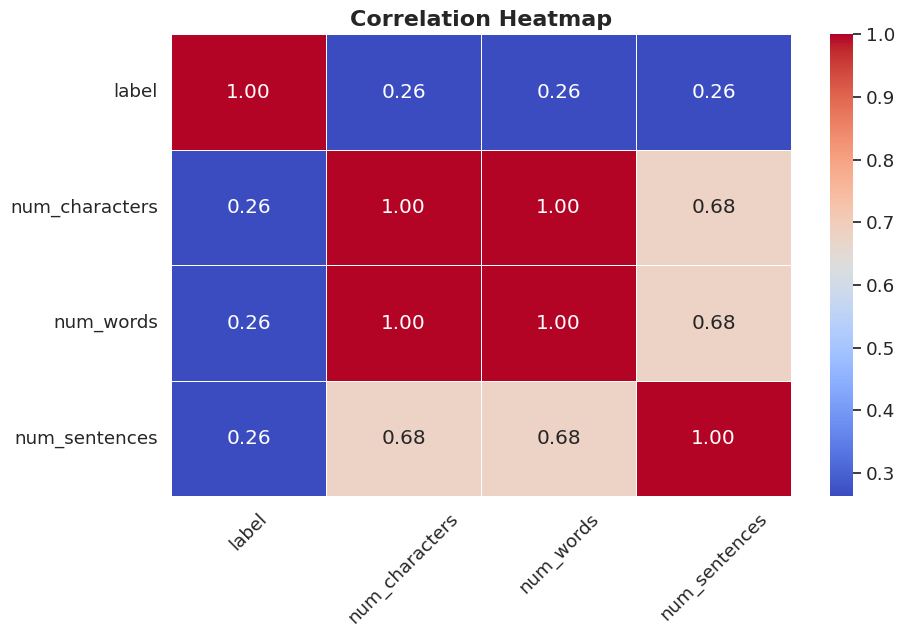

In [46]:
# Select the columns for the correlation matrix
correlation_matrix = data[['label', 'num_characters', 'num_words', 'num_sentences']].corr()

# Create a heatmap with custom styling
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Set a title for the heatmap
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()

WordCloud Generation

Spam

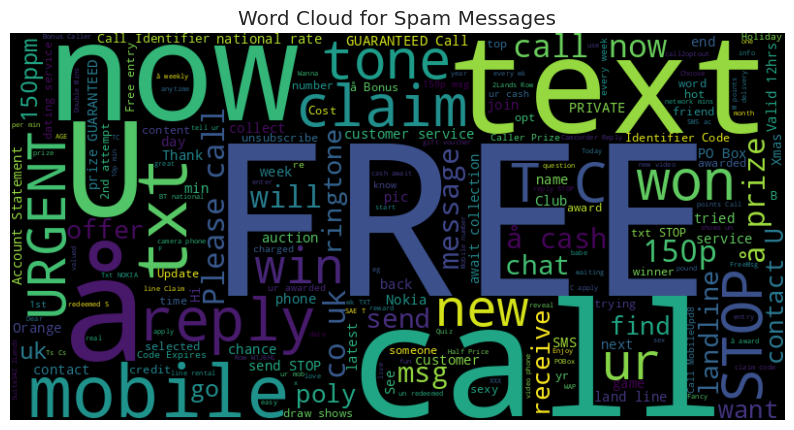

In [47]:
from wordcloud import WordCloud

# Generate a word cloud for spam messages
spam_words = ' '.join(data[data['label'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(spam_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

Ham

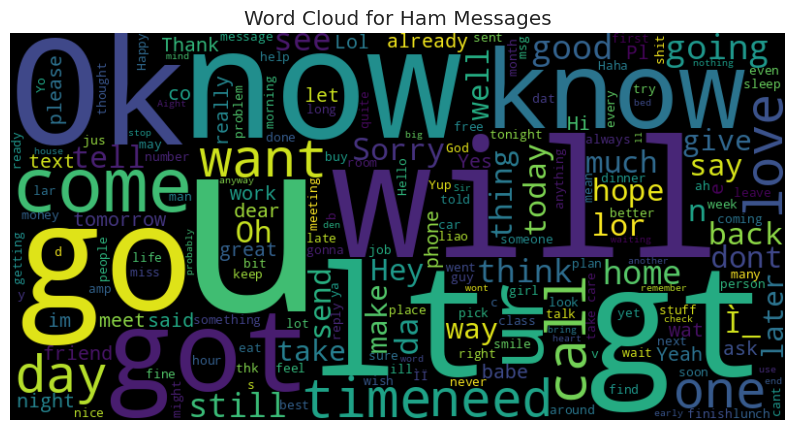

In [48]:
ham_words = ' '.join(data[data['label'] == 0]['text'])
wordcloud_ham = WordCloud(width=800, height=400, background_color='black').generate(ham_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

Find Top 30 Words of Spam Messages

In [49]:
spam_carpos = []
for sentence in data[data['label'] == 1]['text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [50]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

<ipython-input-51-b4964bcadea0>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')


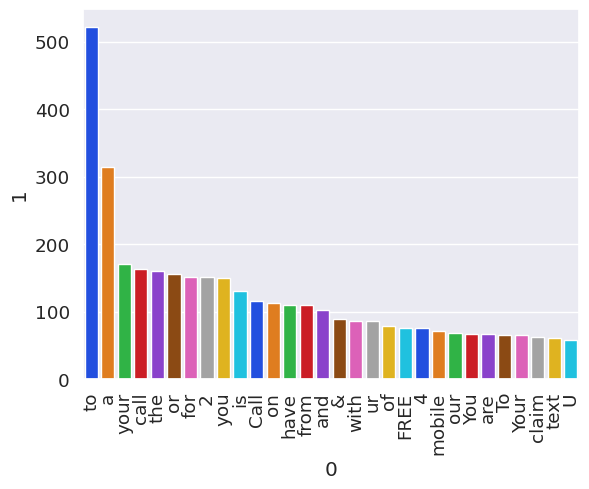

In [51]:
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

Find Top 30 Words of Ham Messages

In [52]:
ham_carpos = []
for sentence in data[data['label'] == 0]['text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)

In [55]:
filter_ham_df = pd.DataFrame(Counter(ham_carpos).most_common(30))

<ipython-input-56-8d8ff60dadd0>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')


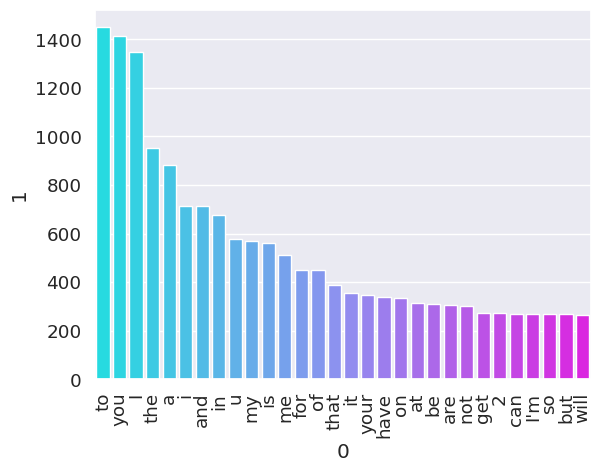

In [56]:
sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

Text Pre Processing

In [57]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_text(text):
    # Remove punctuation and lowercase the text
    text = re.sub(f"[{string.punctuation}]", "", text.lower())
    # Remove stopwords and lemmatize words
    return " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

# Apply text cleaning
data['cleaned_text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


Extraction of Features and Split and Dataset into train and test

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorize cleaned text using TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['cleaned_text']).toarray()
y = data['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Evaluation

In [60]:
# Train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [61]:
# Make predictions
nb_pred = nb_model.predict(X_test)

In [62]:
# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred, target_names=['Ham', 'Spam']))

Naive Bayes Accuracy: 0.9738878143133463
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       889
        Spam       1.00      0.81      0.90       145

    accuracy                           0.97      1034
   macro avg       0.99      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



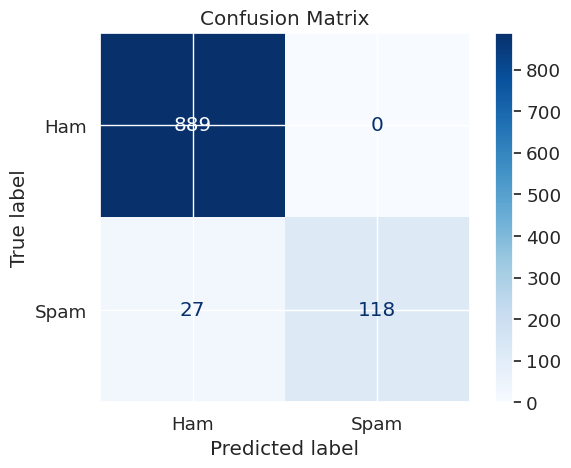

In [63]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

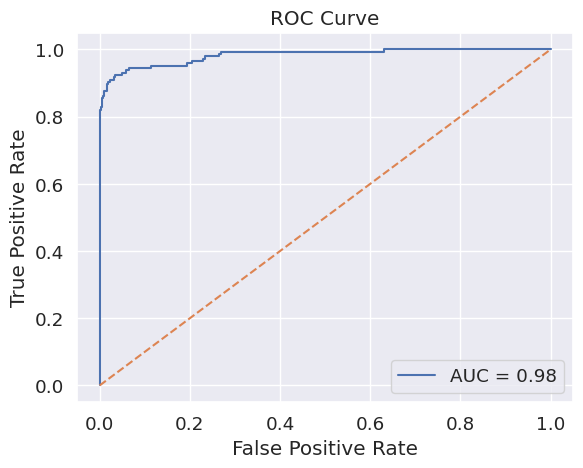

In [64]:
#ROC-AUC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for ROC
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Prediction of Unknown Data

In [69]:

# Example new message (unknown data)
new_message = ["This is a final notice from the IRS. Immediate payment is required to avoid legal action."]

# Clean the new message (use the same cleaning function as before)
new_message_cleaned = [clean_text(msg) for msg in new_message]

# Transform the new message using the TF-IDF vectorizer
new_message_tfidf = tfidf.transform(new_message_cleaned).toarray()

# Predict the label (0 = Ham, 1 = Spam) for the new message
prediction = nb_model.predict(new_message_tfidf)

# Print the result
if prediction == 1:
    print("Spam")
else:
    print("Ham")

Spam
